# Decision Trees 


#### Setting up IPython Notebook
The code below simply sets up the jupyter notebook and displays graphs inline (e.g. as HTML)

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import numpy.linalg as la
np.set_printoptions(precision=3)
def pp_float_list(ps):#pretty print functionality
    return ["%2.3f" % p for p in ps]

# Long-term Goal: Implement the ID3-Algorithm

Experiments are conducted on the [UCI CAR Dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/car/).

We will cover
  
  * Data Setup
  * Impurity functions and impurity reduction
  * ID3 Algorithm for learning a decision tree
  * Classifying unseen examples
  * Evaluation using cross validation

## 1. Data Setup

### 1.1 Download and import the data

In [2]:
#shell scripts for downloading the data and placing it in a corresponding directory
!mkdir CAR 
!curl -o CAR/data "http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
!curl -o CAR/description "http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.names"
#download the description and display it here.
!cat CAR/description

Ein Unterverzeichnis oder eine Datei mit dem Namen "CAR" existiert bereits.


^C


### 1.2 A bit of ugly preprocessing (ignore that part)

In [7]:
# csv-file has no header, so we define it manually
col_names = ['price_buy', 'price_main', 'n_doors', 'n_persons', 'lug_boot', 'safety', 'recommendation']
df = pd.read_csv("./CAR/data", header=None, names=col_names)

# All attributes are categorical - a mix of strings and integers.
# We simply map the categorical values of each attribute to a set of distinct integers
ai2an_map = col_names
ai2aiv2aivn_map = []
enc_cols = []
for col in df.columns:
    df[col] = df[col].astype('category')
    a = np.array(df[col].cat.codes.values).reshape((-1,1))
    enc_cols.append(a)
    ai2aiv2aivn_map.append(list(df[col].cat.categories.values))
    
# Get the data as numpy 2d-matrix (n_samples, n_features)
feature_names = ai2an_map
feature_value_names = ai2aiv2aivn_map[:6]
class_label_names = ai2aiv2aivn_map[6]

dataset = np.hstack(enc_cols)
X, y = dataset[:,:6], dataset[:,6]
print(X.shape, y.shape)

(1728, 6) (1728,)


### 1.3 The data

The data matrix ```X``` contains the preprocessed dataset. Each column corresponds to a feature. The feature names are given in ```feature_names```. The meaning of the feature values are given in ```feature_value_names```. 

The array ```y``` contains the class of each car. The meaning of each class is given in ```class_label_names```.

In [8]:
X, y

(array([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        ...,
        [1, 1, 3, 2, 0, 1],
        [1, 1, 3, 2, 0, 2],
        [1, 1, 3, 2, 0, 0]], dtype=int8),
 array([2, 2, 2, ..., 2, 1, 3], dtype=int8))

In [9]:
feature_names, feature_value_names, class_label_names

(['price_buy',
  'price_main',
  'n_doors',
  'n_persons',
  'lug_boot',
  'safety',
  'recommendation'],
 [['high', 'low', 'med', 'vhigh'],
  ['high', 'low', 'med', 'vhigh'],
  ['2', '3', '4', '5more'],
  ['2', '4', 'more'],
  ['big', 'med', 'small'],
  ['high', 'low', 'med']],
 ['acc', 'good', 'unacc', 'vgood'])

## 2. Impurity functions and impurity reduction
In the following, we will implement the impurity function(s) $\iota(D)$ and impurity reduction function $\Delta\iota(D,\{D_1\ldots D_s\})$.

$$
\iota(D) = \iota\left(\frac{|\{(x,c(x))\in D : c(x) = c_1\}|}{|D|},...,\frac{|\{(x,c(x))\in D : c(x) = c_k\}|}{|D|}\right)
$$

$$
\Delta\iota(D,\{D_1\ldots D_s\}) = \iota(D) - \sum_{j=1}^{s}\frac{|D_j|}{|D|}\cdot\iota(D_j)
$$


### 2.1 Impurity functions

In [1]:
import math


def _entropy(p):
    """
    p: class frequencies as numpy array with np.sum(p)=1
    returns: impurity according to entropy criterion
    """
    # TODO
    
    return -sum([pi * math.log2(pi) for pi in p if pi != 0])

def _gini(p):
    """
    p: class frequencies as numpy array with np.sum(p)=1
    returns: impurity according to gini criterion
    """
    # TODO
    return 1 - sum([pi*pi for pi in p])

def _misclass(p):
    """
    p: class frequencies as numpy array with np.sum(p)=1
    returns: impurity according to misclassification rate
    """
    # TODO
    return 1 - np.max(p)

In [4]:
_entropy(np.array([0.5, 0.5]))

1.0

Lets visualise the functions for the 2D case

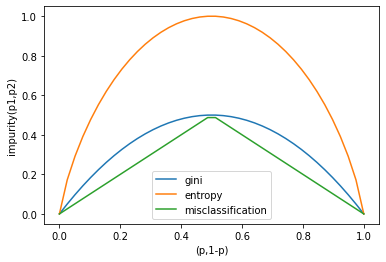

In [5]:
#lets plot the functions for the 2D case 
p1=np.linspace(0,1,40)
imp_gini=[_gini(np.array([p,1-p])) for p in p1]
imp_ent=[_entropy(np.array([p,1-p])) for p in p1]
imp_mc=[_misclass(np.array([p,1-p])) for p in p1]
plt.plot (p1,imp_gini,label="gini")
plt.plot (p1,imp_ent,label="entropy")
plt.plot (p1,imp_mc,label="misclassification")
plt.xlabel("(p,1-p)")
plt.ylabel("impurity(p1,p2)")
plt.legend()
plt.show()

### 2.2 Impurity reduction

In [10]:
def impurity_reduction(X, a_i, y, impurity, verbose=0):
    """
    X: data matrix n rows, d columns
    a_i: column index of the attribute to evaluate the impurity reduction for
    y: class label vector with n rows and 1 column
    impurity: impurity function of the form impurity(p_1....p_k) with k=|X[a].unique|
    returns: impurity reduction / delta
    Note: for more readable code we do not check any assertion 
    """
    
    N, d = int(X.shape[0]), int(X.shape[1]) # 1728.0, 6.0

    y_v = np.unique(y) # array([0, 1, 2, 3], dtype=int8)
    
    # Compute relative frequency of each class in X
    p = (1. / N) * np.array([np.sum(y==c) for c in y_v]) # [0.222 0.04  0.7   0.038]
    
    # ..and corresponding impurity l(D)
    H_p = impurity(p) # 0.2997685185185186
    
    if verbose: print ("\t Impurity %0.3f: %s" % (H_p, pp_float_list(p)))
    
    a_v = np.unique(X[:, a_i]) # [0 1 2 3]
    
    # Create and evaluate splitting of X induced by attribute a_i
    # We assume nominal features and perform m-ary splitting
    
    # TODO
    
    leavesFiltered = []
    yLabelsFiltered = []
    #print(N,d,y_v,p,H_p,a_v)
    for i in range(len(a_v)):
        tempArray = []
        for j in range(N):
            if X[j][a_i] == a_v[i]:
                tempArray.append(X[j][a_i])
                yLabelsFiltered.append(y[j])
        leavesFiltered.append(tempArray)
        #leavesFiltered.append([row for row in X if row[a_i] == a_v[i]])#subtree with first value as root
    leavesFrequency = []
    start = 0
    end = 1
    for i, label in enumerate(a_v):
        end += len(leavesFiltered[i])
        leavesFrequency.append((1./len(leavesFiltered[i])) * np.array([np.sum(yLabelsFiltered[start:end] == c) for c in a_v]))
        start += len(leavesFiltered[i])
    weightedMean = 0
    for i, relFreq in enumerate(leavesFrequency):
        weightedMean += impurity(relFreq) * (len(leavesFiltered[i])/N)
    #print(weightedMean)
    #print(leavesFiltered[0])
    return H_p - weightedMean
purity = [_misclass, _gini, _entropy]
for purr in purity:
    for i in range(6):
        print(purr, "\tdelta =", impurity_reduction(X, i, y, purr), "\tfor column", i)

<function _misclass at 0x000001C9741AEEE0> 	delta = 0.001736111111111105 	for column 0
<function _misclass at 0x000001C9741AEEE0> 	delta = 0.001736111111111105 	for column 1
<function _misclass at 0x000001C9741AEEE0> 	delta = 0.0017361111111111605 	for column 2
<function _misclass at 0x000001C9741AEEE0> 	delta = 0.0011574074074075513 	for column 3
<function _misclass at 0x000001C9741AEEE0> 	delta = 0.0011574074074074958 	for column 4
<function _misclass at 0x000001C9741AEEE0> 	delta = 0.0011574074074074958 	for column 5
<function _gini at 0x000001C9724CF310> 	delta = 0.016567402906378703 	for column 0
<function _gini at 0x000001C9724CF310> 	delta = 0.014032895018861513 	for column 1
<function _gini at 0x000001C9724CF310> 	delta = 0.004018105924211368 	for column 2
<function _gini at 0x000001C9724CF310> 	delta = 0.07091766064386174 	for column 3
<function _gini at 0x000001C9724CF310> 	delta = 0.004529495134602435 	for column 4
<function _gini at 0x000001C9724CF310> 	delta = 0.0742653008

# 3. ID3 Algorithm (later)